In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
from desi_retriever.denali import get_specs
import matplotlib.cm as cm
import scipy.ndimage as sn

In [2]:
def print_simple_number(truth_table,object_type):
    total_N = len(truth_table)
    good_N = len(truth_table[truth_table['best_quality']>=2.5])
    very_good_N = len(truth_table[truth_table['best_quality']==4])
    tmp_table = truth_table.loc[truth_table['best_quality']>=2.5]
    number_of_consistent_z = len(tmp_table.loc[abs(tmp_table['best_z']-tmp_table['Redrock_z'])/(1+tmp_table['best_z'])<0.0033])
    
    print('Number of',object_type,':',total_N)
    print('Number of ',object_type,'with quality>=2.5:',good_N, ' | fration=',good_N*1.0/total_N)
    print('Number of ',object_type,'with quality==4:',very_good_N, ' | fration=',very_good_N*1.0/total_N)
    print('Number of ',object_type,'with consistent z (with quality>=2.5):',number_of_consistent_z, '| fraction=',number_of_consistent_z/total_N)
   
    number_star = len(tmp_table.loc[tmp_table['best_spectype']=='STAR'])
    number_galaxy = len(tmp_table.loc[tmp_table['best_spectype']=='GALAXY'])
    number_qso = len(tmp_table.loc[tmp_table['best_spectype']=='QSO'])
    print('---------')  
    print('Fraction of objects with quality>=2.5')
    print('Star:',number_star*1.0/good_N)
    print('Galaxy:',number_galaxy*1.0/good_N)    
    print('QSO:',number_qso*1.0/good_N)

    plt.hist(truth_table['best_quality'],bins=8,range=(0,4))
    plt.ylabel('Number')
    plt.xlabel('Quality')
    plt.yscale('log')
    plt.xlim(0,4)
  

In [3]:
def plot_redshift_distribution(truth_table,object_type):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    x_range = [0,max(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'])]
    plt.hist(truth_table['best_z'],range=(x_range[0],x_range[1]),bins=20,color='b',label='All')
    plt.hist(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'],range=(x_range[0],x_range[1]),bins=20,color='orange',label='quality>=2.5')
    plt.hist(truth_table.loc[truth_table['best_quality']==4]['best_z'],range=(x_range[0],x_range[1]),bins=20,color='g',label='quality=4')
    plt.yscale('log')
    plt.xlabel('Best z')
    plt.ylabel('Number')
    plt.legend()
    plt.title(object_type)
    
    plt.subplot(1,2,2)
    plt.scatter(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'],truth_table.loc[truth_table['best_quality']>=2.5]['Redrock_z'],
                
                c=truth_table.loc[truth_table['best_quality']>=2.5]['best_quality'],cmap=cm.jet)
    plt.xlabel('Best z')
    plt.ylabel('Redrock z')
    plt.colorbar()

In [4]:
def plot_chi2_quality_distribution(truth_table):
    #plt.scatter(truth_table['best_quality'],truth_table['DELTACHI2'])
    #plt.ylim(1,100000)
    #plt.yscale('log')
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.hist(np.log10(truth_table['DELTACHI2']),label='All',bins=8,range=(0,5),color='b')
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']>=2.5]['DELTACHI2']),color='orange',label='flag>=2.5',bins=8,range=(0,5))
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']==4]['DELTACHI2']),color='g',label='flag=4',bins=8,range=(0,5),)
    plt.xlabel('$log_{10}$ delta chi$^{2}$')
    plt.ylabel('Number')
    plt.yscale('log')
    plt.legend()
    plt.subplot(1,2,2)
    
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']<2.5]['DELTACHI2']),color='grey',label='flag<2.5',bins=8,range=(0,5),histtype='step',lw=4)
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']>=2.5]['DELTACHI2']),color='orange',label='flag>=2.5',bins=8,range=(0,5),histtype='step',lw=4)
    #plt.hist(np.log10(truth_table.loc[truth_table['best_quality']==4]['DELTACHI2']),color='g',label='flag=4',bins=8,range=(0,5),histtype='step',lw=4)

    plt.xlabel('$log_{10}$ delta chi$^{2}$')
    plt.ylabel('Number')
    plt.yscale('log')
    plt.legend()    
    
    
    
    

In [5]:
def give_me_ra_dec_object_with_property_cut(truth_table, property_name, cut, if_print=True):
    tmp_table = truth_table.loc[(truth_table[property_name]>=cut[0]) & (truth_table[property_name]<cut[1])]
    if if_print==True:
        for i_object in range(0,len(tmp_table)):
            print(tmp_table['TARGET_RA'].values[i_object],tmp_table['TARGET_DEC'].values[i_object])
    
    return tmp_table

In [8]:
# The filenames are tentative. We will change the filenames.
on_nersc=False
if on_nersc==True:
    dir = '/global/cfs/cdirs/desi/sv/vi/TruthTables/Cascades/'
    BGS = pd.read_csv(dir+'BGS/'+'desi-vi_SV_cascades_combination_BGS_all_210521.csv')
    BGS['DELTACHI2']=BGS['Redrock_deltachi2']
    LRG = pd.read_csv(dir+'LRG/'+'desi-vi_SV_cascades_combination_LRG_all_210521.csv')
    LRG['DELTACHI2']=LRG['Redrock_deltachi2']
    ELG = pd.read_csv(dir+'ELG/'+'desi-vi_SV_cascades_combination_ELG_all_210521.csv')
    ELG['DELTACHI2']=ELG['Redrock_deltachi2']
    #ELG_80606 = pd.read_csv(dir+'ELG/'+'desi-vi_ELG_tile80606_nightdeep_merged_all_210218.csv')
else:
    #dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Truth_tables/'
    QSO = pd.read_csv('/Users/blue/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV_VI_cascades/Cascades/QSO/desi-vi_SV_cascades_combination_QSO_all_210611_with_object_properties.csv')
    #QSO['DELTACHI2']=QSO['Redrock_deltachi2']
    #LRG = pd.read_csv(dir+'desi-vi_LRG_tile80609_nightdeep_merged_all_210130.csv')
   

In [14]:
QSO['setting_name']

0           QSO_missed
1           QSO_missed
2           QSO_missed
3           QSO_missed
4           QSO_missed
             ...      
2455    QSO_single_exp
2456    QSO_single_exp
2457    QSO_single_exp
2458    QSO_single_exp
2459    QSO_single_exp
Name: setting_name, Length: 2460, dtype: object

In [9]:
denali_all = Table.read('/Volumes/Elements/DESI/Denali/zcatalog-denali-cumulative.fits')
#denali_all = denali_all[denali_all['coadd_type']=='cumulative']

In [13]:
new_catalog_denali = denali_all['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','LAST_NIGHT',
                              'FIBERFLUX_R','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER'].to_pandas()

# QSO missing QSO

Number of QSO : 1836
Number of  QSO with quality>=2.5: 1736  | fration= 0.9455337690631809
Number of  QSO with quality==4: 1024  | fration= 0.5577342047930284
Number of  QSO with consistent z (with quality>=2.5): 1088 | fraction= 0.5925925925925926
---------
Fraction of objects with quality>=2.5
Star: 0.005184331797235023
Galaxy: 0.08122119815668202
QSO: 0.913594470046083


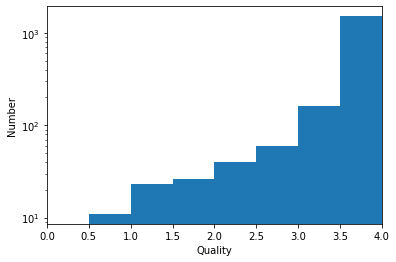

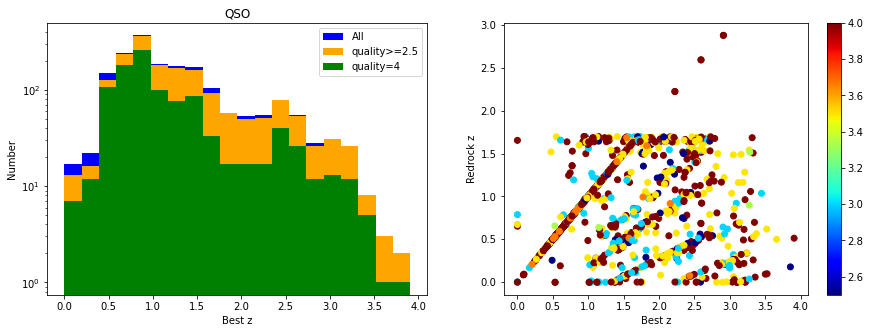

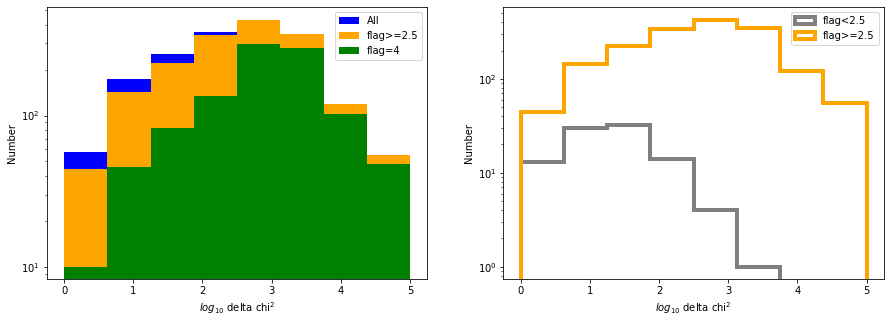

In [15]:
QSO_main = QSO[QSO['setting_name']=='QSO_missed']
print_simple_number(QSO_main,'QSO')
plot_redshift_distribution(QSO_main,'QSO')
plot_chi2_quality_distribution(QSO_main)

In [19]:
catalog_QSO_match = QSO_main.merge(new_catalog_denali,on='TARGETID',how='left',suffixes=("_cascades","_denali"))
final_match_catalog = catalog_QSO_match[catalog_QSO_match['TILEID_cascades']==catalog_QSO_match['TILEID_denali']]
final_match_catalog['dz']=abs(final_match_catalog['Z_denali']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
final_match_catalog['Redrock_z']=final_match_catalog['Z_denali']



<ipython-input-19-8bb8c68d6a38>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz']=abs(final_match_catalog['Z_denali']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
<ipython-input-19-8bb8c68d6a38>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Redrock_z']=final_match_catalog['Z_denali']


Number of QSO : 1836
Number of  QSO with quality>=2.5: 1736  | fration= 0.9455337690631809
Number of  QSO with quality==4: 1024  | fration= 0.5577342047930284
Number of  QSO with consistent z (with quality>=2.5): 1115 | fraction= 0.6072984749455338
---------
Fraction of objects with quality>=2.5
Star: 0.005184331797235023
Galaxy: 0.08122119815668202
QSO: 0.913594470046083


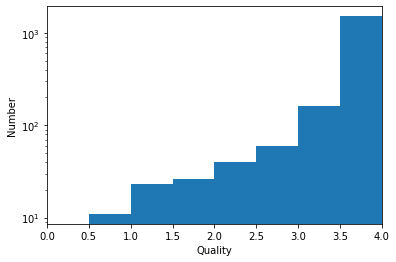

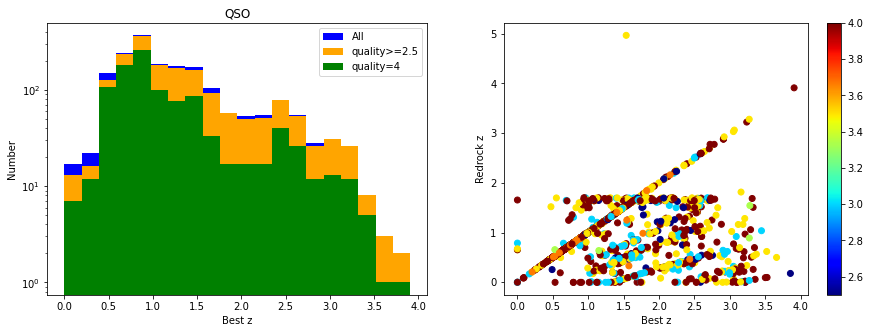

In [20]:
print_simple_number(final_match_catalog,'QSO')
plot_redshift_distribution(final_match_catalog,'QSO')

In [21]:
cut_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & (final_match_catalog['best_quality']>=2.5)]

In [24]:
cut_catalog.columns

Index(['TARGETID', 'Redrock_z', 'best_z', 'best_quality', 'Redrock_spectype',
       'best_spectype', 'all_VI_issues', 'all_VI_comments', 'merger_comment',
       'N_VI', 'setting_name', 'Z_cascades', 'TILEID_cascades',
       'TARGET_RA_cascades', 'TARGET_DEC_cascades', 'DELTACHI2_cascades',
       'FIBERFLUX_R_cascades', 'FLUX_R_cascades', 'FIBERFLUX_Z_cascades',
       'FLUX_W1_cascades', 'FLUX_G_cascades', 'FLUX_Z_cascades',
       'EBV_cascades', 'ZWARN_cascades', 'FIBER_cascades', 'Z_denali',
       'TILEID_denali', 'DELTACHI2_denali', 'TARGET_RA_denali',
       'TARGET_DEC_denali', 'LAST_NIGHT', 'FIBERFLUX_R_denali',
       'FLUX_R_denali', 'FIBERFLUX_Z_denali', 'FLUX_W1_denali',
       'FLUX_G_denali', 'FLUX_Z_denali', 'EBV_denali', 'ZWARN_denali',
       'FIBER_denali', 'dz'],
      dtype='object')

In [29]:
data_dict ={}
QSO_tile = np.array(cut_catalog['TILEID_denali'])
targetid = np.array(cut_catalog['TARGETID'])
fiberid = np.array(cut_catalog['FIBER_denali'])
last_night = np.array(cut_catalog['LAST_NIGHT'])
print('Targetid, fiberid, tileid')
for i in range(0,10):
    if QSO_tile[i]==80619:
        last_night[i]=20210321
    if QSO_tile[i]==80612.0:
        last_night[i]=20201223 
    if QSO_tile[i]==80650.0:
        last_night[i]=20210322
    if QSO_tile[i]==80643.0:
        last_night[i]=20210308        
    if QSO_tile[i]==80686:
        last_night[i]=20210309
        
    print(targetid[i],fiberid[i],QSO_tile[i],last_night[i])
    data_dict[i]=get_specs(tileid=int(QSO_tile[i]), coadd_type='cumulative', night=int(last_night[i]), fiber=int(fiberid[i]))
   

Targetid, fiberid, tileid
39632984738895088 966 80677 20210205
39632984759866421 254 80677 20210205
39632984772444403 4635 80677 20210205
39632984965383343 2933 80685 20210216
39632984986357405 3468 80685 20210216
39632985019911429 2958 80686 20210309
39632985045074022 3389 80686 20210309
39632989683979372 921 80677 20210205
39632994612287021 1298 80677 20210205
39632999528006656 1153 80677 20210205


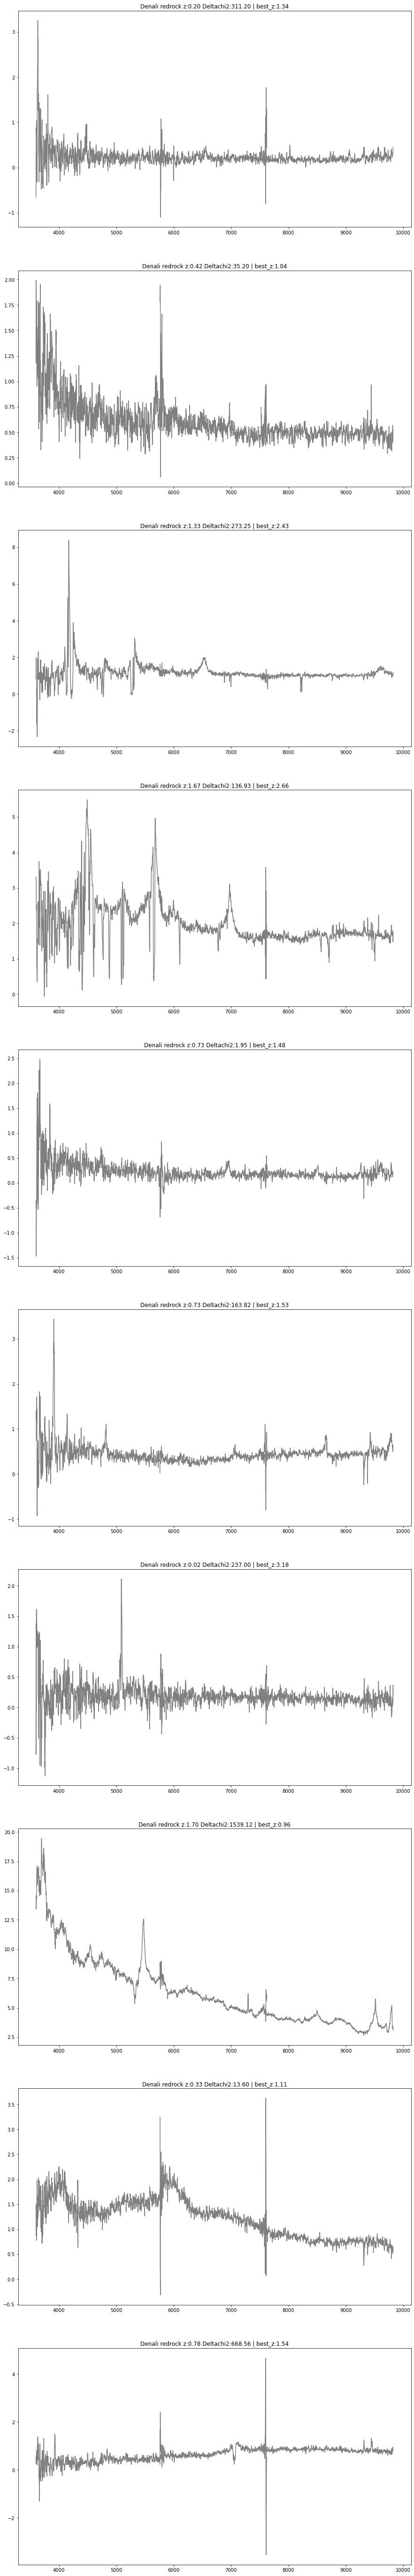

In [34]:
plt.figure(figsize=(15,100))
index = np.argsort(np.array(cut_catalog['Redrock_z']))
index = np.arange(0,len(index))
for i in range(0,10):
    plt.subplot(10,1,i+1)
    plt.plot(data_dict[index[i]][0]['b_wavelength'],sn.median_filter(data_dict[index[i]][0]['b_flux'],10),color='grey')
    plt.plot(data_dict[index[i]][0]['r_wavelength'],sn.median_filter(data_dict[index[i]][0]['r_flux'],10),color='grey')
    plt.plot(data_dict[index[i]][0]['z_wavelength'],sn.median_filter(data_dict[index[i]][0]['z_flux'],10),color='grey')
    plt.title('Denali redrock z:%0.2f Deltachi2:%0.2f | best_z:%0.2f' % (np.array(cut_catalog['Redrock_z'])[index[i]],np.array(cut_catalog['DELTACHI2_denali'])[index[i]],np.array(cut_catalog['best_z'])[index[i]]))

In [35]:
for i in range(0,len(index)):
    print(targetid[index[i]],fiberid[index[i]],QSO_tile[index[i]],np.array(cut_catalog['Redrock_z'])[index[i]])


39632984738895088 966 80677 0.1973125845938236
39632984759866421 254 80677 0.41830048129580366
39632984772444403 4635 80677 1.326626243543657
39632984965383343 2933 80685 1.6702679545873997
39632984986357405 3468 80685 0.7292474762411109
39632985019911429 2958 80686 0.7280515088575297
39632985045074022 3389 80686 0.01602015525144494
39632989683979372 921 80677 1.6984877669079483
39632994612287021 1298 80677 0.3290158386215343
39632999528006656 1153 80677 0.7768858286805044
39632999540591042 3965 80677 1.3142600985513024
39632999553173932 4368 80677 1.5416034291857095
39633004431152665 3319 80677 1.4981557359760715
39633004439535876 3537 80677 1.0635301470037963
39633009300740677 2101 80677 0.7096517451492111
39633009304931909 2626 80677 1.251243605400242
39633009317512980 3735 80677 1.628183484961256
39633018989582376 2194 80677 -0.0038915144161765164
39628516727197949 289 80699 1.497783332491817
39628516731391619 4867 80622 0.9212080785194043
39628516731391619 4850 80699 0.92119435042

39632939864034673 4514 80685 0.5493558330454149
39632939918559640 4938 80686 0.4149575766910069
39632950031027807 262 80686 0.5515701799383148
39632950035219338 273 80686 0.36081234818069063
39632950039413770 4586 80686 1.2580586115142292
39632950039415571 4957 80686 1.655087011193811
39632950047802015 2745 80682 0.4811745298874194
39632950047804242 4805 80686 0.8055950079885653
39632950047805441 2728 80682 0.4522564756472248
39632950047805441 4811 80686 1.3450221213478244
39632950182021136 2681 80690 1.1577204732689728
39632950236547458 2686 80692 1.1655618949647315
39632950236548624 2681 80692 1.1615606149613915
39632950463039739 2665 80622 1.3576495202519288
39632950484009608 3480 80699 1.6666140570302408
39632950517564393 2685 80700 1.0205377685897736
39632954946752912 2684 80681 0.9750643787400491
39632954950944449 2863 80681 0.3992725095821023
39633252318708409 4914 80711 2.08092039336622
39633256173274630 23 80711 0.3298561862809027
39633267636308181 1167 80711 0.55662124688066


# QSO with none repeatable

In [36]:
QSO['setting_name']

0           QSO_missed
1           QSO_missed
2           QSO_missed
3           QSO_missed
4           QSO_missed
             ...      
2455    QSO_single_exp
2456    QSO_single_exp
2457    QSO_single_exp
2458    QSO_single_exp
2459    QSO_single_exp
Name: setting_name, Length: 2460, dtype: object

Number of QSO : 624
Number of  QSO with quality>=2.5: 569  | fration= 0.9118589743589743
Number of  QSO with quality==4: 362  | fration= 0.5801282051282052
Number of  QSO with consistent z (with quality>=2.5): 450 | fraction= 0.7211538461538461
---------
Fraction of objects with quality>=2.5
Star: 0.24253075571177504
Galaxy: 0.37961335676625657
QSO: 0.37785588752196836


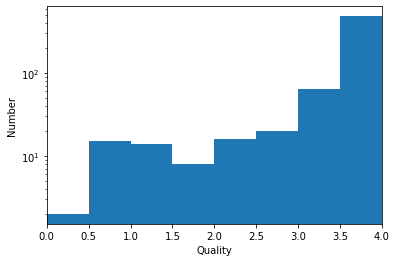

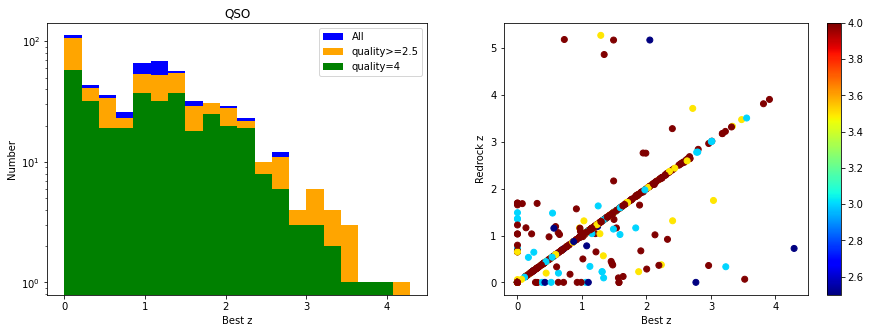

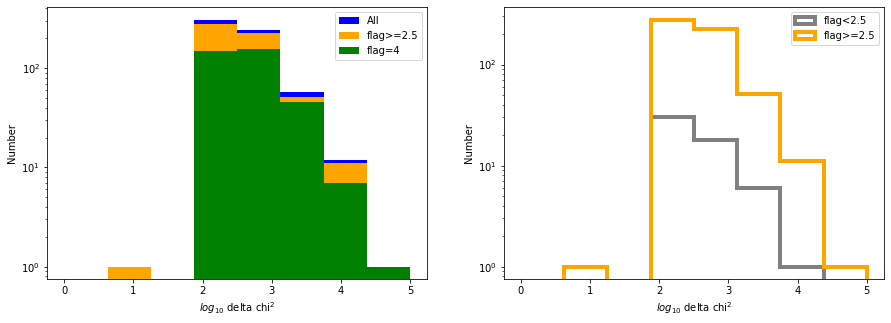

In [37]:
QSO_main = QSO[QSO['setting_name']=='QSO_single_exp']
print_simple_number(QSO_main,'QSO')
plot_redshift_distribution(QSO_main,'QSO')
plot_chi2_quality_distribution(QSO_main)

In [38]:
catalog_QSO_match = QSO_main.merge(new_catalog_denali,on='TARGETID',how='left',suffixes=("_cascades","_denali"))

### Comparing the Denali redshift and the best z

The consistency increases from 20% to 70%!!

In [39]:
final_match_catalog = catalog_QSO_match[catalog_QSO_match['TILEID_cascades']==catalog_QSO_match['TILEID_denali']]
#plt.scatter(final_match_catalog['Redrock_z'][final_match_catalog['TILEID_denali']==80643],final_match_catalog['Z'][final_match_catalog['TILEID_denali']==80643])

<ipython-input-41-1e8348aa0631>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Redrock_z']=final_match_catalog['Z_denali']


Number of QSO : 624
Number of  QSO with quality>=2.5: 569  | fration= 0.9118589743589743
Number of  QSO with quality==4: 362  | fration= 0.5801282051282052
Number of  QSO with consistent z (with quality>=2.5): 451 | fraction= 0.7227564102564102
---------
Fraction of objects with quality>=2.5
Star: 0.24253075571177504
Galaxy: 0.37961335676625657
QSO: 0.37785588752196836


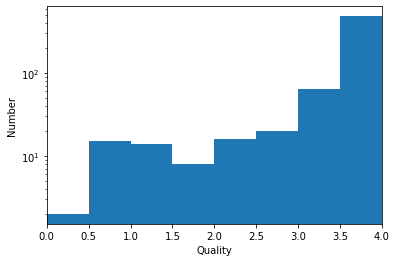

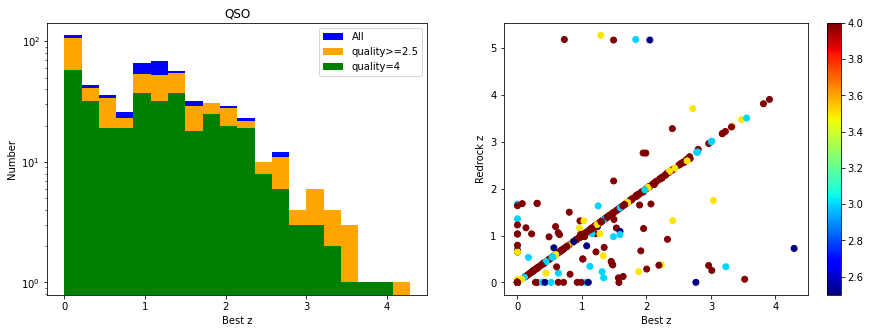

In [41]:
final_match_catalog['Redrock_z']=final_match_catalog['Z_denali']
print_simple_number(final_match_catalog,'QSO')
plot_redshift_distribution(final_match_catalog,'QSO')
#plot_chi2_quality_distribution(final_match_catalog)

In [44]:
final_match_catalog['dz']=abs(final_match_catalog['Z_denali']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])

<ipython-input-44-fb9010356e1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz']=abs(final_match_catalog['Z_denali']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])


In [45]:
cut_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & (final_match_catalog['best_quality']>=2.5)]

In [48]:
data_dict ={}
QSO_tile = np.array(cut_catalog['TILEID_denali'])
targetid = np.array(cut_catalog['TARGETID'])
fiberid = np.array(cut_catalog['FIBER_denali'])
last_night = np.array(cut_catalog['LAST_NIGHT'])
print('Targetid, fiberid, tileid')
for i in range(0,10):
    if QSO_tile[i]==80619:
        last_night[i]=20210321
    if QSO_tile[i]==80612.0:
        last_night[i]=20201223        
    print(targetid[i],fiberid[i],QSO_tile[i],last_night[i])
    data_dict[i]=get_specs(tileid=int(QSO_tile[i]), coadd_type='cumulative', night=int(last_night[i]), fiber=int(fiberid[i]))
   

Targetid, fiberid, tileid
39632955504593181 2666 80622 20201221
39632955559119846 2695 80700 20210208
39632955563312551 2672 80700 20210208
39632960252546941 2687 80690 20210216
39632960256738813 2670 80690 20210216
39632960311265297 2675 80692 20210214
39632960315459112 2667 80692 20210214
39632960588090052 2678 80700 20210208
39632960592282006 2670 80700 20210208
39632984965385164 2681 80685 20210216


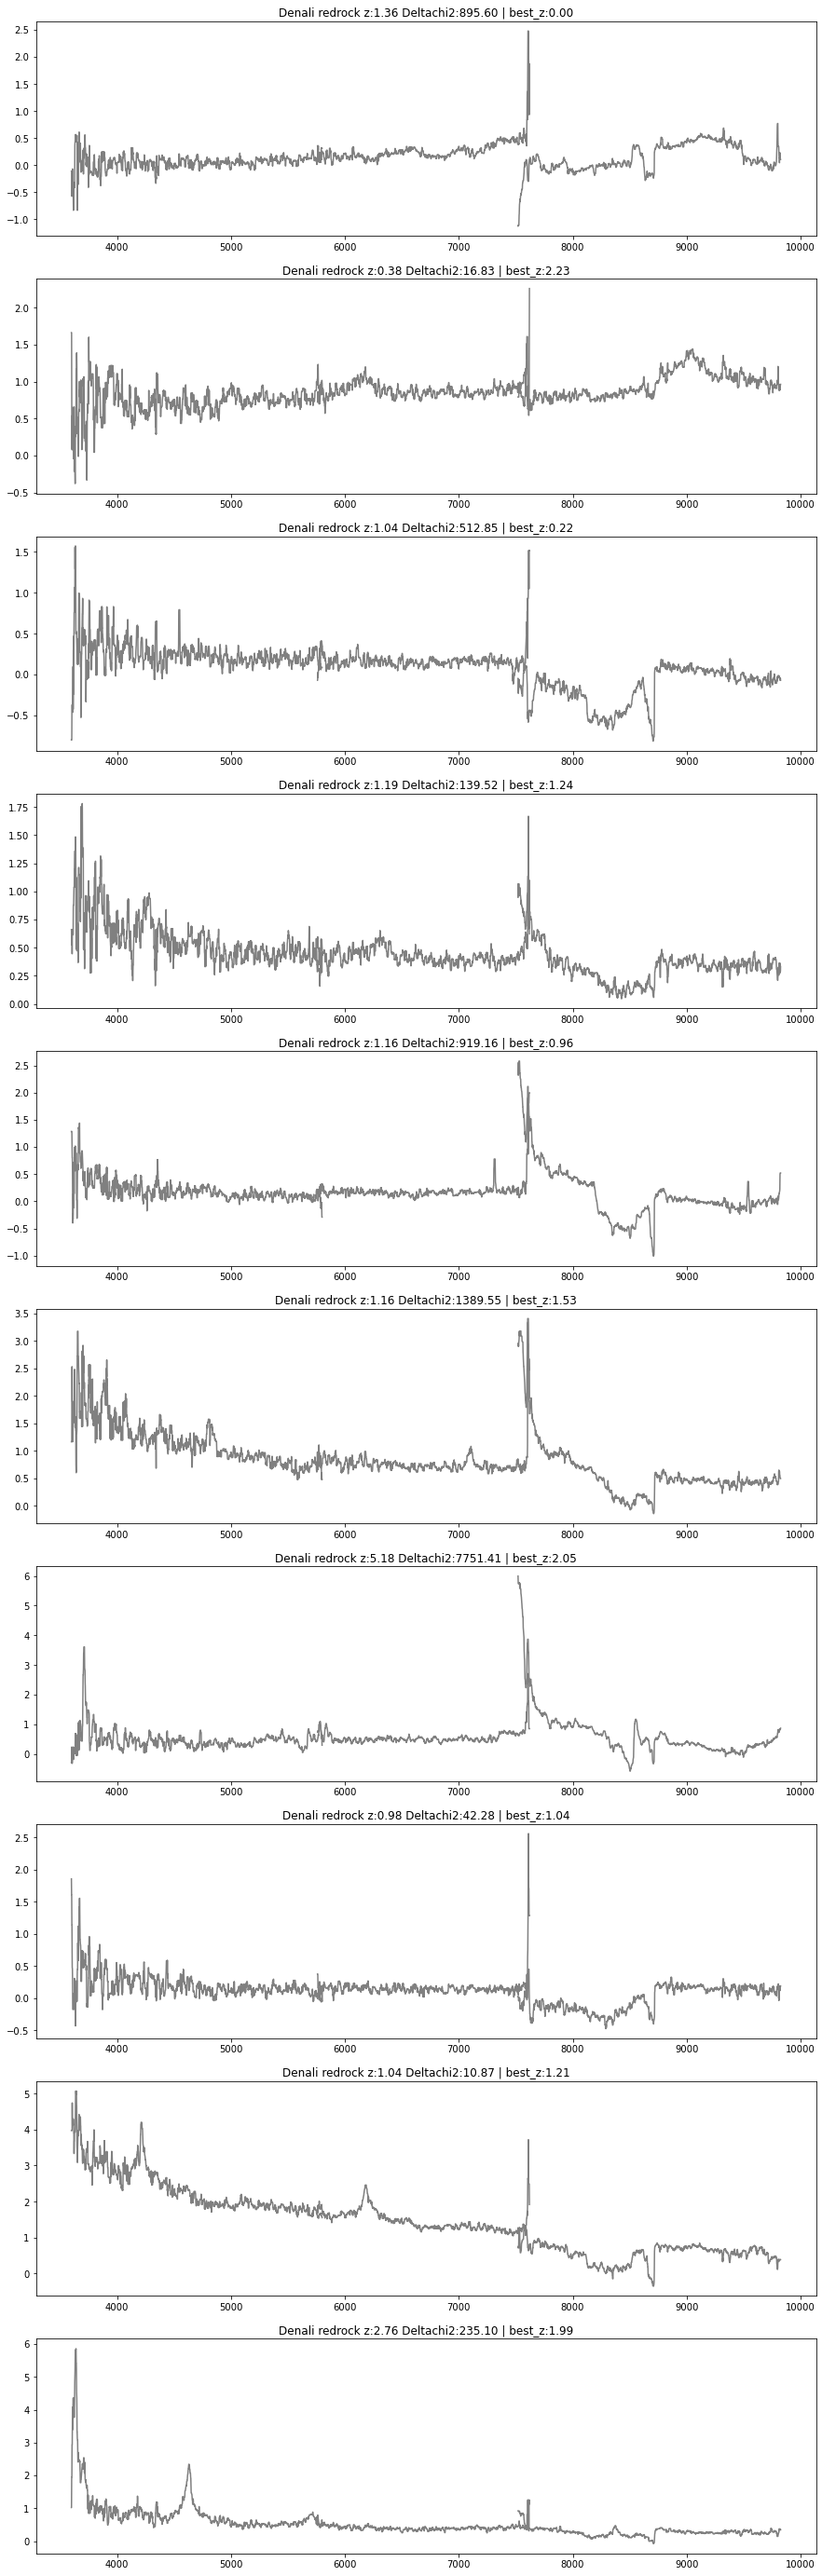

In [50]:
plt.figure(figsize=(15,50))
#index = np.argsort(np.array(cut_catalog['Redrock_z']))
index = np.arange(0,len(index))
for i in range(0,10):
    plt.subplot(10,1,i+1)
    plt.plot(data_dict[index[i]][0]['b_wavelength'],sn.median_filter(data_dict[index[i]][0]['b_flux'],20),color='grey')
    plt.plot(data_dict[index[i]][0]['r_wavelength'],sn.median_filter(data_dict[index[i]][0]['r_flux'],20),color='grey')
    plt.plot(data_dict[index[i]][0]['z_wavelength'],sn.median_filter(data_dict[index[i]][0]['z_flux'],20),color='grey')
    plt.title('Denali redrock z:%0.2f Deltachi2:%0.2f | best_z:%0.2f' % (np.array(cut_catalog['Redrock_z'])[index[i]],np.array(cut_catalog['DELTACHI2_denali'])[index[i]],np.array(cut_catalog['best_z'])[index[i]]))

In [51]:
for i in range(0,len(index)):
    print(targetid[index[i]],fiberid[index[i]],QSO_tile[index[i]],np.array(cut_catalog['Redrock_z'])[index[i]])


39632955504593181 2666 80622 1.3571626785983992
39632955559119846 2695 80700 0.3754114707900861
39632955563312551 2672 80700 1.03527131476481
39632960252546941 2687 80690 1.1940589752048385
39632960256738813 2670 80690 1.161605344136907
39632960311265297 2675 80692 1.1624225882779147
39632960315459112 2667 80692 5.175090998279399
39632960588090052 2678 80700 0.9767853819199833
39632960592282006 2670 80700 1.0405466631840885
39632984965385164 2681 80685 2.7606198130062687
39632989675586230 1216 80677 1.149140768455123
39632989906275646 2674 80685 1.0193184490184295
39632994889107763 2670 80686 5.186436747672109
39633028640670681 333 80678 1.0334486469259176
39633033422178603 857 80678 3.8613404760705216e-05
39633038207881332 591 80678 0.12565869564623405
39633182395467725 3059 80680 0.0007766796934834939
39633186585576716 2666 80680 5.275104050472264
39633190775687139 2675 80680 0.9763739926400967
39633198908445241 1216 80676 0.7226726054212881
39633198941995371 4683 80676 0.53331526819

IndexError: index 118 is out of bounds for axis 0 with size 118